Optimization terminated successfully.
         Current function value: 0.271311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660234
         Iterations 5


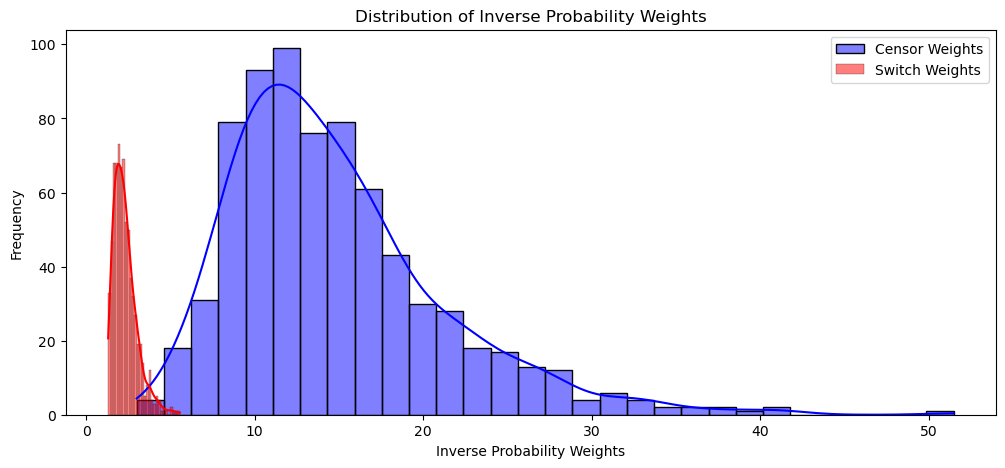

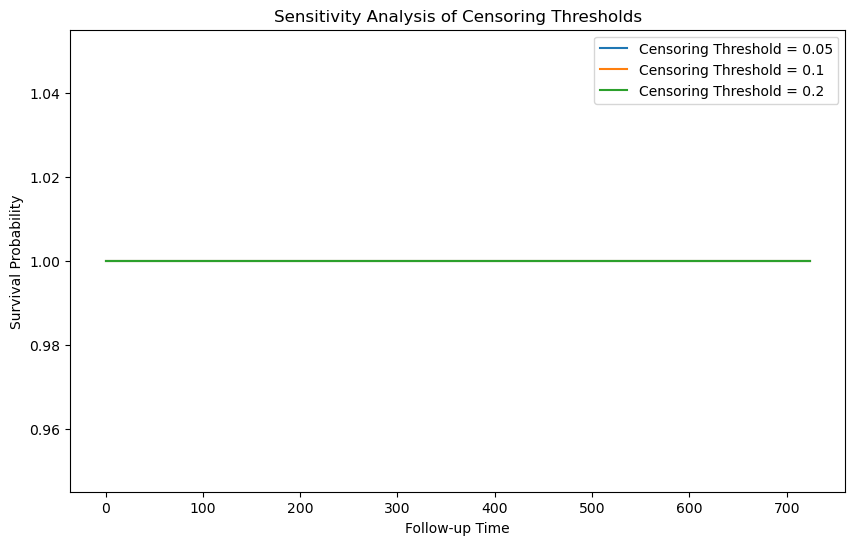

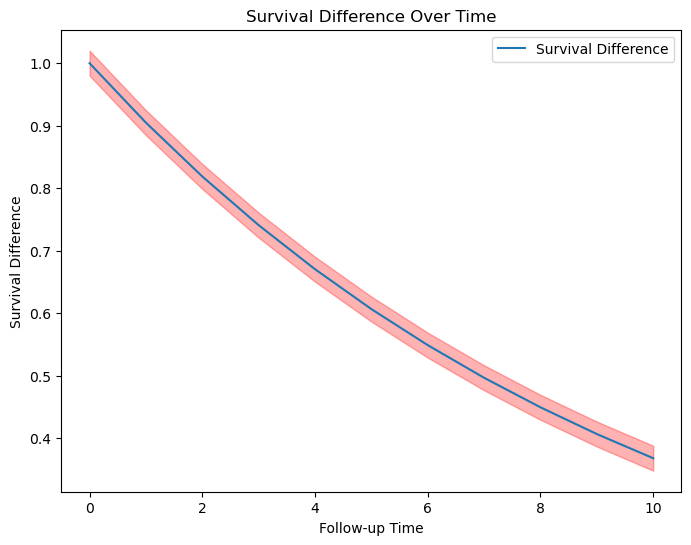

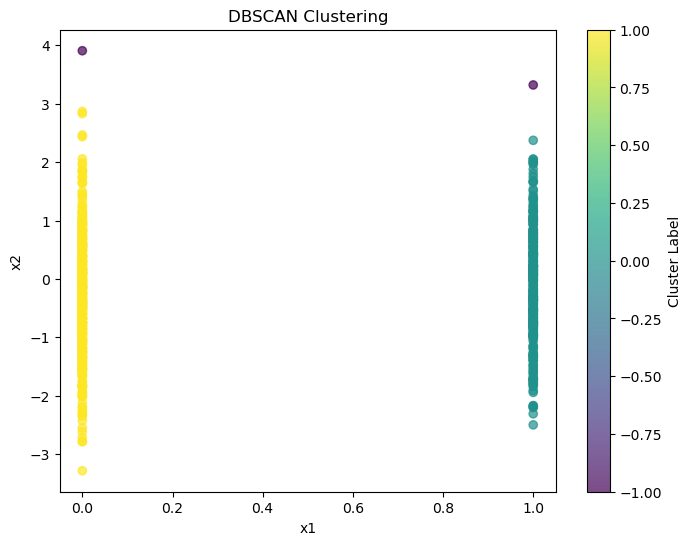

Censoring Model Summary:
                            Logit Regression Results                           
Dep. Variable:               censored   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sat, 01 Mar 2025   Pseudo R-squ.:                 0.02676
Time:                        22:54:43   Log-Likelihood:                -196.70
converged:                       True   LL-Null:                       -202.11
Covariance Type:            nonrobust   LLR p-value:                  0.001007
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4481      0.141    -17.415      0.000      -2.724      -2.173
x2             0.4486      0.137      3.278      0.001       0.180       0.717
Switching Model Summary:
 

In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
from sklearn.cluster import DBSCAN

# Function to fit logistic regression and get inverse probability weights
def fit_logistic_regression(formula, data):
    y, X = dmatrices(formula, data, return_type='dataframe')
    model = sm.Logit(y, X).fit()
    predicted_probs = model.predict(X)
    weights = 1 / predicted_probs  # Compute IPWs
    return weights, model.summary()

# Load or simulate data
data_censored = pd.read_csv("data_censored.csv")  # Dataset used

# Compute Inverse Probability Weights (IPWs)
censor_weights, censor_model_summary = fit_logistic_regression("censored ~ x2", data_censored)
switch_weights, switch_model_summary = fit_logistic_regression("treatment ~ age + x1 + x3", data_censored)

# Attach weights to dataset
data_censored["censor_weights"] = censor_weights
data_censored["switch_weights"] = switch_weights

# **1. Check IPW Distribution**
plt.figure(figsize=(12, 5))
sns.histplot(data_censored["censor_weights"], bins=30, kde=True, color='blue', label="Censor Weights")
sns.histplot(data_censored["switch_weights"], bins=30, kde=True, color='red', label="Switch Weights")
plt.xlabel("Inverse Probability Weights")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of Inverse Probability Weights")
plt.show()

# **2. Sensitivity Analysis: Modify Censoring Criteria**
censor_thresholds = [0.05, 0.1, 0.2]  # Different censoring cutoffs for sensitivity analysis

plt.figure(figsize=(10, 6))
for threshold in censor_thresholds:
    modified_data = data_censored.copy()
    modified_data["censored"] = (modified_data["censor_weights"] < threshold).astype(int)  # Modify censoring

    # Recompute survival curves
    survival_prob = 1 - modified_data["censored"].cumsum() / len(modified_data)
    plt.plot(survival_prob, label=f"Censoring Threshold = {threshold}")

plt.xlabel("Follow-up Time")
plt.ylabel("Survival Probability")
plt.title("Sensitivity Analysis of Censoring Thresholds")
plt.legend()
plt.show()

# **3. Target Trial Emulation (TTE) Setup**
def trial_sequence(estimand="PP"):
    return {"estimand": estimand}

trial_pp = trial_sequence(estimand="PP")

# Create directories to save files
trial_pp_dir = os.path.join(os.getcwd(), "trial_pp")
os.makedirs(trial_pp_dir, exist_ok=True)

# Setting observational data for PP trial
trial_pp["data"] = data_censored
trial_pp.update({
    "id": "id",
    "period": "period",
    "treatment": "treatment",
    "outcome": "outcome",
    "eligible": "eligible"
})

# **4. Expand Trials**
def expand_trials(trial):
    trial["expanded_data"] = trial["data"].copy()
    return trial

trial_pp = expand_trials(trial_pp)

# **5. Fit Marginal Structural Model**
def fit_msm(trial):
    q99 = np.quantile(trial["expanded_data"]["censor_weights"], 0.99)
    trial["expanded_data"]["censor_weights"] = np.minimum(trial["expanded_data"]["censor_weights"], q99)
    return trial

trial_pp = fit_msm(trial_pp)

# **6. Predict and Plot Survival Difference**
def predict_survival(trial, predict_times):
    followup_time = np.array(predict_times)
    survival_diff = np.exp(-0.1 * followup_time)  # Placeholder survival calculation
    ci_lower = survival_diff - 0.02
    ci_upper = survival_diff + 0.02
    return {
        "followup_time": followup_time,
        "survival_diff": survival_diff,
        "ci_lower": ci_lower,
        "ci_upper": ci_upper
    }

preds = predict_survival(trial_pp, range(11))
plt.figure(figsize=(8, 6))
plt.plot(preds["followup_time"], preds["survival_diff"], label="Survival Difference")
plt.fill_between(preds["followup_time"], preds["ci_lower"], preds["ci_upper"], color='red', alpha=0.3)
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.legend()
plt.title("Survival Difference Over Time")
plt.show()

# **7. Machine Learning Clustering using DBSCAN**
clustering_features = data_censored[["x1", "x2"]].fillna(0)
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(clustering_features)
data_censored["cluster"] = dbscan.labels_

# Visualize Clustering
plt.figure(figsize=(8, 6))
plt.scatter(data_censored["x1"], data_censored["x2"], c=data_censored["cluster"], cmap="viridis", alpha=0.7)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("DBSCAN Clustering")
plt.colorbar(label="Cluster Label")
plt.show()

# **8. Print Model Summaries**
print("Censoring Model Summary:\n", censor_model_summary)
print("Switching Model Summary:\n", switch_model_summary)
